# Empirical Orthogonal Function/Principal Component Analysis

## Qualitative Overview
Empirical orthogonal function analysis (EOF) is equivalent to principal component analysis (PCA), though for historical reasons the technique is referred to most frequently in the oceanographic literature as EOFs. In this notebook, the oceanographic terms for elements of this technique will be referred to. The primary use of EOF analysis in oceanography is to understand the dominant patterns of variability (the empirical orthogonal functions) within a given dataset and the strength of those patterns over time (the principal components). Technique is often applied to datasets with dimensions of space and time such that the EOFs are stationary in time, but the PCs vary. 

While the technique can be extended in a number of ways, the simplest application (as applied to a spatiotemporal datsaet) identifies the spatial pattern that explains the most of the variance within the dataset. Two primary methods to calculate EOFs and PCs exist 
1.  Perform an eigenvector/eigenvalue decomposition of the datasets covariance matrix 
2.  Apply a Singular Value Decomposition (SVD) of the the original dataset 
As can be shown, these two procedures are equivalent, but have some subtle differences in actual implementation. The outcome of the analysis is to have a spatial map representing the regression of a timeseries at each grid point onto the EOF (i.e. eigenvector) and a single timeseries (PC) representing the normalized 'strength' of that EOF for every time slice.

To illustrate this more clearly, consider a dataset containing monthly anomalies of sea surface temperature from the period 1870-2005. 
## Mathematical overview
## SVD way
In the case of model output (used here), this data begins as a three dimensional array of time, latitude, and longitude. For practical purposes, this 3d array is flattened to a 2d array ($A$) with dimensions of $m \times n$ where $m$ is the number of stations and $n$ is the number of timeslices. Any preprocessing (e.g. weighting or pre-whitening) should be applied generating a new matrix $\tilde{A}$. An SVD decomposition on this array yields
\begin{equation}
\tilde{A} = U S V^\top
\end{equation}
In this way, the EOFs are the columns of the $V$ matrix and the principal components are can be calculated either by projecting the $A$ onto the EOF, or from the SVD decomposition as $U \times S$
## Covariance way
Given the same pre-processed matrix $A$ whose columns represent all the time slices of a given station, the covariance $C$ can be calculated as
\begin{equation}
C = A^\top A/(n-1)
\end{equation}
yiedling a symmetric $m\times m$ matrix. Due to these properties, the eigenspace of $C$ is unique and can be calculated. 
## Comments
It can be shown that these two approaches are mathematically identical, however I've heard it argued that SVD is more numerically stable. I'm not entirely sure why, but I suspect that numerical issues can come into play depending on the algorithms used to calculate eigenvectors on the covariance matrix. 

# Demonstration

In [84]:
import xarray as xr
import scipy.sparse.linalg
import glob
import numpy as np
import matplotlib.pyplot as plt

In [172]:
datapath = '../data/ESM2G/'
files = glob.glob(datapath + '*.nc');files.sort()
# uncomment for the entire historical period
data = xr.open_mfdataset(files)
# data = xr.open_dataset(files[-1])
ntime,nlat,nlon = data.tos.shape
# Create a land(=0) sea(=1) mask 
mask = np.tile(np.array(xr.ufuncs.logical_not(xr.ufuncs.isnan(data.tos[0,:,:]))),[ntime,1,1])
nstations = np.int(mask.sum()/ntime)
# Calculate the anomalies, should probably also weight by area and detrend, but for simplicity ignore for now
monthly_average = data.tos.groupby('time.month').mean('time')
tos_anomaly = np.array(data.tos.groupby('time.month') - monthly_average)

/HOME/ras/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [173]:
# Flatten and shape data array on which SVD will be performed
tos_presvd = tos_anomaly.ravel()[mask.ravel()].reshape(ntime,nstations)
# Peform an SVD to get the first 5 eofs
U, S, V = scipy.sparse.linalg.svds(tos_presvd, k = 6)
PCs = U*S

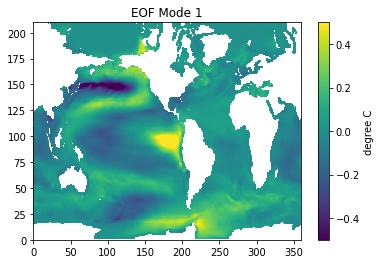

In [190]:
# Reshape back onto a spatial map 
eof1 = np.zeros((nlat,nlon))
# Multiply by sqrt of the first singular value (variance units) to dimensionalize eigenvector
eof1[mask[0,:,:]] = V[0,:]*np.sqrt(S[0]) 
eof1 = np.ma.masked_where(np.logical_not(mask[0,:,:]),eof1)
plt.pcolormesh(eof1,vmin=-0.5,vmax=0.5); plt.title('EOF Mode 1'); ax = plt.colorbar()
ax.set_label('degree C')

Text(0.5,1,'Principal Component 1')

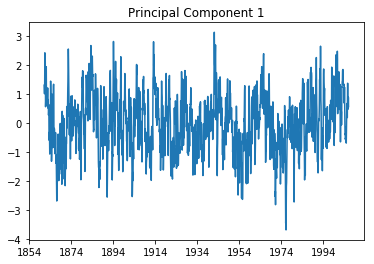

In [177]:
plt.plot(data.time,PCs[:,0]/np.std(PCs[:,0])); plt.title('Principal Component 1')
plt.ylabel('standard deviation')

In [179]:
S[0]

968.21661